# Week 8 Day 2: Fitting distributions

## Objectives:
* Talk a bit about errors in Python
* Look at fitting simple distributions, binned and unbinned
* Mention other libraries for fitting

#### Note on terminology

I try to introduce the relevant terminology when we talk about new subject.

This is not meant to spew jargon at you, but rather to give you something you can Google.

## Errors

* The most serious sort of error: A segfault
    - Issue with the underlying compiled code
    - *Very* rare in Python itself, can be intentionally caused or a bug in libraries
* Most errors are "Exceptions": A control flow feature in Python - and you can act on and work with them!
    - You can even use Exceptions for things that are not errors

### Exceptions

Exceptions are designed to interrupt the control flow for "exceptional" events. This makes writing safe code much easier - could you imagine if every function had to return an error status, and you had to check the status and also return your own error status if it was bad? (If you can imagine it, congratulations, you can write C code).

Imagine this:

In [1]:
def f(x):
    s = 0
    for i in range(10):
        if x == 0:
            return 0, "Error in calculations"
        s += i / x
    return s, ""


value, error = f(0)

if error:
    print(error)
else:
    print(value)

Error in calculations


Compare to this:

In [2]:
def f(x):
    s = 0
    for i in range(10):
        if x == 0:
            raise RuntimeError("Error in calculations")
        s += i / x
    return s


try:
    value = f(0)
    print(value)
except RuntimeError as e:
    print(e)

# Try running this without the try/catch to see the full exception printout

Error in calculations


The benefits to the second example:

* This nests; the in-between functions don't need to know about the Exception in the inner function or the check in the outer function
    - Exceptions just bubble up through the stack
* This keeps errors from interfering with the function return values
* If we remove the Exception checking, we get a Python error message
* If we remove the check, Python automatically throws an exception when you divide by zero!
* The code is faster if we don't throw an exception often

In [3]:
def f(x):
    s = 0
    for i in range(10):
        s += i / x
    return s


try:
    value = f(0)
    print(value)
except ZeroDivisionError as e:
    print(e)

division by zero


So now we see that Python has a ZeroDivisionError, and it is raised when you divide by zero. So we can now make a function that can take 0's without making an explicit check for 0!

In [4]:
def direction_xy(vec):
    """
    This takes a direction vector vec[0], vec[1], vec[2], and
    returns the x and y componets of a vector with length 1 z component.
    If the length of z is 0, returns [0,0].
    """

    try:
        return vec[0] / vec[2], vec[1] / vec[2]
    except ZeroDivisionError:
        return vec[0] * 0, vec[1] * 0


def direction_xy_classic(vec):
    if vec[2] == 0:
        return vec[0] * 0, vec[1] * 0
    else:
        return vec[0] / vec[2], vec[1] / vec[2]

The version that does not check will be faster when the exception is not caught - you are not paying for an extra check:

In [5]:
%%timeit
direction_xy((1, 2, 3))

228 ns ± 5.15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
%%timeit
direction_xy_classic((1, 2, 3))

244 ns ± 7.61 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


However, the exception catching mechanism is slower than the normal control flow if it does get caught a lot:

In [7]:
%%timeit
direction_xy((1, 2, 0))

495 ns ± 12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
%%timeit
direction_xy_classic((1, 2, 0))

182 ns ± 3.53 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### Exception throwing

You have a large collection of standard exceptions in Python:

* <https://docs.python.org/3.7/library/exceptions.html>

You can make a new one trivially:

```python
class MyException(RuntimeError):
    pass
```

### Exception catching

You put the code that might throw an exception in a `try:` block.

You put the possible exception catching parts in one or more `except Name:` block following that. It contains the name of the exception type - you can list multiple exception type to catch, and any subclasses will also be caught. You can optionally keep a reference to the exception to use by using `as`. You can even reraise the exception with `raise`. You can also `raise Err() from y` (Python 3) to give users a more explicit traceback. Or `raise Err() from None` to give a less explicit traceback (hides the original exception).

You optionally can put in a `else` block which runs if no exceptions were caught, and a `finally` block, which runs no-matter-what (for cleanup, usually). See [this or PEP 341](https://docs.python.org/2.5/whatsnew/pep-341.html).

Here's a playground for you. Try changing the caught exception type to `RuntimeError` and then another type of error, and experiment a bit.

In [9]:
class MyException(RuntimeError):
    pass


def f():
    raise MyException()


try:
    f()
except MyException:
    print("Caught Exception!")

Caught Exception!


### Common example: Optional import

Let's say you want to import a package, but you are fine if it doesn't exist - you'll just deactivate some features. Here's the standard way to do it:

In [10]:
try:
    import some_fancy_printout_package_that_does_not_exist
except ImportError:
    some_fancy_printout_package_that_does_not_exist = None

if some_fancy_printout_package_that_does_not_exist:
    print("Using fancy printout")
else:
    print("Not using fancy printout")

Not using fancy printout


In Python, it is often **better to ask for forgiveness than to ask for permission**.

This is can be better in more ways than just performance. What happens if you check for the existence of a file, find it exists, then try to open it, just to find it was deleted in the meantime?

### Warnings

Warnings are special - since they should not interrupt the control flow normally. So Python provides a `warning` module, with a `warn` function. It print a message unless you request warnings to be treated as errors, in which case it raises an error.

---

# Fitting distributions

We can fit distributions with Python - though we'll need to look around a bit to find good ways to fit more complex distributions. Let's try the simplest case and SciPy first:

In [11]:
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

In [12]:
gauss_X = norm.rvs(1, 2, 100_000)

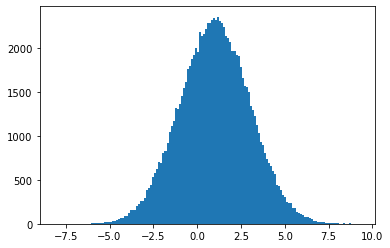

In [13]:
plt.hist(gauss_X, bins="auto")
plt.show()

In [14]:
mean, sigma = norm.fit(gauss_X)
print(f"mean = {mean}, sigma = {sigma}")

mean = 1.0065071075918135, sigma = 1.996862989360223


Note that we have no error information, no pretty much anything... Just a result.

And, we can make a ND Gaussian, including covariance:

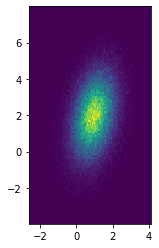

In [15]:
XY = multivariate_normal.rvs([1, 2], cov=[[0.5, 0.3], [0.3, 2]], size=100_000)
plt.hist2d(*XY.T, bins=100)
plt.gca().set_aspect("equal")
plt.show()

But... Multivariate norm is missing a fit function! Ugh...

### Fitting by hand

You already know how to bin and fit:

In [16]:
from scipy.optimize import curve_fit, minimize

Reminder, curve fits wants a function that take 1 data parameter followed by functional parameters:

<!--
vals, edges = np.histogram(gauss_X, bins=25)
errs = 1/np.sqrt(vals)
vals = vals / np.sum(vals) / (edges[1] - edges[0])
centers = (edges[1:] + edges[:-1])/2
curve_fit(norm.pdf, centers, vals, [1,1], sigma=errs)
-->

In [17]:
vals, edges = np.histogram(gauss_X, bins=25, density=True)
centers = (edges[1:] + edges[:-1]) / 2
curve_fit(norm.pdf, centers, vals, [1, 1])

(array([1.00521372, 2.01258831]),
 array([[3.90532963e-05, 9.02398970e-12],
        [9.02398970e-12, 2.60355554e-05]]))

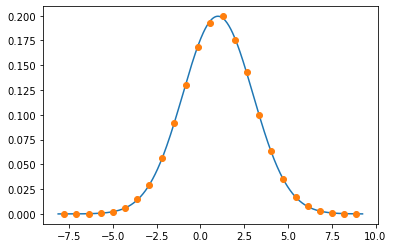

In [18]:
xs = np.linspace(edges[0], edges[-1], 500)
plt.plot(xs, norm.pdf(xs, 1, 2))
plt.plot(centers, vals, "o")
plt.show()

Unbinned is not quite as easy, but we can still do it explicitly. We want to minimize an NLL:

$$
NLL = -\sum_i \ln\left( P(x_i) \right)
$$

The minimize function in scipy.optimize takes:

* A function to minimize. It must take an iterable of parameters as the first argument. You can pass through other arguments using `args`.
* An initial guess for parameters
* Optional args to pass through.

In [19]:
def NLL_gauss(params, x):
    mu, sigma = params
    y = norm.pdf(x, mu, sigma)
    return -np.sum(np.log(y))

In [20]:
minimize(NLL_gauss, [0.9, 1.8], args=(gauss_X,))

      fun: 211051.59770524627
 hess_inv: array([[ 2.19280286e-05, -4.23436707e-05],
       [-4.23436707e-05,  8.31699723e-05]])
      jac: array([0.00195312, 0.00195312])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 282
      nit: 8
     njev: 68
   status: 2
  success: False
        x: array([1.0065072 , 1.99686298])

In [21]:
type(_)

scipy.optimize.optimize.OptimizeResult

Try methods to fix the `success=False`:

* Set a low `tol=` parameter
* Increase the number of samples
* Try `method = 'Nelder-Mead'`

Warning: we've skipped something important by using the Gaussian pdf from Scipy: It is normalized! We need normalized PDF functions for this to work. If you write your own, you need a normalized function.

## Other tools

So, this can be done by hand; but several things are missing:

* Easy ways to build distribution PDFs, especially combinations
    * Even would be nicer if high-speed/GPU calculations possible
* Extra error information, including asymmetric errors
* Pretty fitting API
* Better parameter limit control, and nice API
* Automatic derivatives of fitting function (though you can pass a manual one!)

Some packages exist:

* [LMFit][]: Seems to be one of the common tools outside of HEP - it doesn't seem to like unbinned fits, though.
* [iMinuit][] and [probfit][]: HEP tools made available to normal Pythonistas. Probfit pip package broken on Python 3.
* [RooFit][]: A ROOT tool for fitting. Very powerful, very slow, very hard to install and keep from segfaulting
* [GooFit][]: A GPU/OpenMP tool, fast but new PDFs must be added in C++/CUDA.

[LMFit]: http://cars9.uchicago.edu/software/python/lmfit_MinimizerResult/index.html
[iMinuit]: https://iminuit.readthedocs.io/en/latest/
[probfit]: https://probfit.readthedocs.io/en/latest/
[RooFit]: http://roofit.sourceforge.net
[GooFit]: https://goofit.github.io

The general design is somewhat similar. You need the following pieces:

* Parameters: variables you minimize
* Data: The input data - often provides Observables for each dimension
* Models: Common "parts" that you can combine
* Normalization: When fitting, you need to normalize for the NLL to work. (Missing in LMFit?)
* Fitter: something to do the fitting

In [22]:
from lmfit.models import GaussianModel, LinearModel

In [23]:
gauss_part = np.random.normal(1, 2, size=100_000)
lin_part = np.random.uniform(low=-10, high=10, size=50_000)
total_rand = np.concatenate([gauss_part, lin_part])

In [24]:
model = GaussianModel(prefix="gauss_") + LinearModel(prefix="lin_")

In [25]:
vals, edges = np.histogram(total_rand, bins=25, density=True)
centers = (edges[1:] + edges[:-1]) / 2
res = model.fit(vals, x=centers)

In [26]:
print(res.success)

True


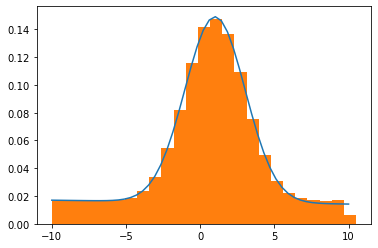

In [27]:
x = np.linspace(-10, 10)
y = model.eval(params=res.params, x=x)
plt.plot(x, y)
plt.hist(total_rand, bins=25, density=True)
plt.show()

### Probfit

If you do want to try probfit: The latest git version supports Python 3 (last release on PyPI: 2013). I'm bugging the new maintainer now. `pip install --user git+https://github.com/iminuit/probfit.git#egg=probfit`

### GooFit

If you really want to try GooFit, you can try this on OSC:

```
!pip install --user scikit-build cmake
!PATH=$HOME/.local/bin:$PATH pip install --user --verbose goofit
```

The extra requirements here are partially to ensure it gets the highest level of optimization, and partially requirements that will eventually go away.

If you are on macOS, scikit-build is broken, you'll need `!pip install scikit-build==0.6.1`.

In [28]:
import goofit

In [29]:
x = goofit.Observable("x", -10, 10)

In [30]:
data = goofit.UnbinnedDataSet(x)

In [31]:
data.from_matrix([total_rand], filter=True)

In [32]:
goofit.PolynomialPdf


If the Gaussian is the potato, what is the
polynomial? Bread? Milk? Nothing exotic, at any rate. The GooFit
version does have some subtleties, to allow for polynomials over an
arbitrary number[^1] of dimensions:

$$
    P(\vec x; \vec a, \vec x_0, N) =
    \sum\limits_{p_1+p_2+\ldots+p_n \le N} a_{p_1p_2\ldots p_n} \prod\limits_{i=1}^n (\vec x - \vec x_0)_i^{p_i}
$$

where $N$ is the highest degree of the polynomial and $n$ is the
number of dimensions. The constructor takes a `vector` of
observables, denoted $\vec x$ above; a `vector` of coefficients,
$\vec a$, a `vector` of optional offsets $\vec x_0$ (if not
specified, these default to zero), and the maximum degree $N$. The
coefficients are in the order
$a_{p_0p_0\ldots p_0}, a_{p_1p_0\ldots p_0}, \ldots a_{p_Np_0\ldots p_0}, a_{p_0p_1\ldots p_0}, a_{p_1p_1\ldots p_0},
\ldots a_{p_0p_0\ldots p_N}$. In other words, start at the index for
the constant term, and increment the power of the leftmost
observable. Every time the sum of the powers reaches $N$, reset the
leftmost power to zero and increment the next-leftmost. When the
next-leftmost reaches $N$, reset it to zero and increment the
third-leftmost, and so on.

An example may be helpful; for two
dimensions $x$ and $y$, and a maximum power of 3, the order is
$a_{00}, a_{10}, a_{20}, a_{30}, a_{01}, a_{11}, a_{21}, a_{02}, a_{12}, a_{03}$.
This can be visualised as picking boxes out of a matrix and
discarding the ones where the powers exceed the maximum:

$$
\begin{array}{cccc}
    9: x^0y^3 &    -      &    -      &    -      \\
    7: x^0y^2 & 8: x^1y^2 &    -      &    -      \\
    4: x^0y^1 & 5: x^1y^1 & 6: x^2y^1 &    -      \\
    0: x^0y^0 & 1: x^1y^0 & 2: x^2y^0 & 3: x^3y^0 \\
\end{array}
$$

starting in the lower-lefthand corner and going right,
then up.

There is also a simpler version of the constructor for the case of a
polynomial with only one dimension; it takes the observable, a
`vector` of coefficients, an optional offset, and the lowest (not
highest) degree of the polynomial; the latter two both default to
zero. In this case the order of the coefficients is from lowest to
highest power.

[^1]: Although being honest, just supporting the special cases of one and two would likely have
sufficed.


In [33]:
a = goofit.Variable("a", 0, 0, 1)
linear = goofit.PolynomialPdf("linear", x, [a])

In [34]:
mu = goofit.Variable("mu", 0, -10, 10)
sigma = goofit.Variable("sigma", 1, 0, 5)
gauss = goofit.GaussianPdf("gauss", x, mu, sigma)

In [35]:
frac = goofit.Variable("frac", 0.5, 0, 1)
total = goofit.AddPdf("tot", [frac], [gauss, linear])

In [36]:
minimum = total.fitTo(data)

MnSeedGenerator: for initial parameters FCN = 840472.0648868
MnSeedGenerator: Initial state:   - FCN =   840472.0648868 Edm =        54298 NCalls =     19
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   840472.0648868 Edm =        54298 NCalls =     19
VariableMetric: Iteration #   0 - FCN =   840472.0648868 Edm =        54298 NCalls =     19
VariableMetric: Iteration #   1 - FCN =   804589.0158624 Edm =      5601.11 NCalls =     32
VariableMetric: Iteration #   2 - FCN =   794336.7320449 Edm =      1917.73 NCalls =     43
VariableMetric: Iteration #   3 - FCN =   791715.9798809 Edm =       3.3531 NCalls =     53
VariableMetric: Iteration #   4 - FCN =   791710.5750437 Edm =    0.0691817 NCalls =     63
VariableMetric: Iteration #   5 - FCN =   791710.4652668 Edm =   0.00388528 NCalls =     73
VariableMetric: Iteration #   6 - FCN =    791710.461159 Edm =  1.74294e-07 NCalls =     83

Minuit did successfully converge.
# of function calls:

In [37]:
print(frac)

frac: 0.6673 +/- 0.0015 [0, 1] Fitter index: 0


Let's look at a plot.

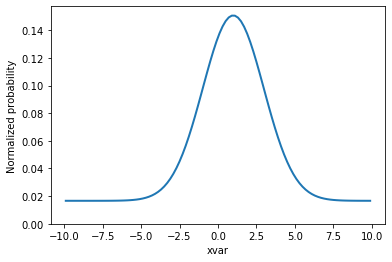

In [38]:
grid, pts = total.evaluatePdf(x)
total.setData(grid)

fig, ax = plt.subplots(figsize=(6, 4))
v = ax.plot(grid.to_numpy().flatten(), pts, linewidth=2)[0]
ax.set_xlabel("xvar")
ax.set_ylabel("Normalized probability")
ax.set_ylim(ymin=0)
plt.show()